## Create Feed Forward Neural Network
- 1 input, 1 output, with 1 hidden layer and 2 neurons with some weights, 100 data points

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim


def activation_function(x, func): # could add ReLU, Leaky ReLU, or Softmax
    if func == 'sigmoid':
        return(1/(1 + np.exp(-x)))
    elif func == 'tanh':
        return np.tanh(x)


class FFNN_Generator(object):

    def __init__(self, node_layers:list[int]=[]):
        self.node_layers = node_layers
        self.weight_matrix = []
        self.init_weights()
    
    def init_weights(self):
        if len(self.node_layers) > 1:

            for i in range(len(self.node_layers)-1):
                # rows of the weight matrix are the from # of inputs
                rows = self.node_layers[i]
                # columns of the weight matrix are the neurons in the layer
                columns = self.node_layers[i+1]
                weights = np.random.rand(rows, columns)
                self.weight_matrix.append(weights)
    

    def feedforward(self, input):
        I = input # I is input to the next layer
        out = None
        print(self.weight_matrix)
        for i, weight in enumerate(self.weight_matrix):
            I_W = np.dot(I, weight)

            if i == (len(self.weight_matrix) - 1):
                out = activation_function(I_W, 'tanh') # output layer
            else:
                I = activation_function(I_W, 'tanh') # updating inputs for hidden layers
        return out # output matrix shape (1x100)
    
    
    

# instantiate this neural network
Data_Generator = FFNN_Generator([1, 2, 1])

 


# input 1, 1 hidden layer (2 neurons therefore 1*2 = 2 weights), 1 output
# hidden layer (2 weights * 100 inputs) -> shape is (2x100)
# output matrix shape (1x100)

## Generate Data From First Network

In [2]:
input = np.random.rand(100, 1)
data = Data_Generator.feedforward(input)
target_weights = Data_Generator.weight_matrix

# convert to tensors
data = torch.tensor(data, dtype = torch.float32)
target_weights = [torch.tensor(weight, dtype = torch.float32) for weight in target_weights]

# concatenate weights into a single tensor as the second NN expects weights to have same shape as output
target_weights = torch.cat([weight.flatten() for weight in target_weights]).unsqueeze(0)

print("Generated Data:", data[:5])
print("Feed Forward Neural Network 1 Weights:", target_weights)


[array([[0.75811918, 0.59683049]]), array([[0.1377002 ],
       [0.70603635]])]
Generated Data: tensor([[0.3008],
        [0.4194],
        [0.3340],
        [0.0030],
        [0.2421]])
Feed Forward Neural Network 1 Weights: tensor([[0.7581, 0.5968, 0.1377, 0.7060]])


## Create Second Neural Network
- use data created by first neural network to train this second RNN 
- use adam optimizer to investigate weight decay
- 2 scenarios: firstly, leave at default, no regularization, second, give some value that is supposed to help training (maybe look at adam and weight decay parameter documentaiton)

In [3]:
class FFNN_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN_Predictor, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size, bias = False) # remove bias
        self.tanh = nn.Tanh()
        self.ho = nn.Linear(hidden_size, output_size, bias = False) # remove bias
    
    def forward(self, x):
        out = self.fc(x)
        out = self.tanh(out)
        out = self.ho(out)

        return out

# instantiate second networks
predictor1 = FFNN_Predictor(input_size = data.shape[1], hidden_size = 2, output_size = 1)
predictor2 = FFNN_Predictor(input_size = data.shape[1], hidden_size = 2, output_size = 1)

# loss arrays for plotting
loss_no_decay = []
loss_decay = []


## Testing the Weight Decay with Two Training Sets

In [ ]:
# loss function
learning_rate = 0.01
criterion = nn.MSELoss() 
optimizer = optim.Adam(predictor1.parameters(), lr=learning_rate) # FFNN_parameters provides the parameters (weight and biases) to be updated as training progresses

# could try 1 and 2 neurons

# train model
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()

    # predict weights of generated data neural network
    predicted_weights = predictor1(data)

    # compute loss
    loss1 = criterion(predicted_weights, target_weights)
    loss1.backward()

    # update weights of this second neural network
    optimizer.step()

    loss_no_decay.append(loss1.item())
    print(f"Epoch {epoch}/{epochs}, Loss: {loss1.item()}")

# after training, grab the weights predicted by the second neural netowrk
predicted_weights1 = {name: param.data.numpy() for name, param in predictor1.named_parameters()}




Epoch 0/100, Loss: 0.4507908523082733
Epoch 1/100, Loss: 0.44642338156700134
Epoch 2/100, Loss: 0.44208118319511414
Epoch 3/100, Loss: 0.4377649426460266
Epoch 4/100, Loss: 0.4334753453731537
Epoch 5/100, Loss: 0.429212749004364
Epoch 6/100, Loss: 0.4249774217605591
Epoch 7/100, Loss: 0.4207693040370941
Epoch 8/100, Loss: 0.4165884256362915
Epoch 9/100, Loss: 0.41243454813957214
Epoch 10/100, Loss: 0.4083072543144226
Epoch 11/100, Loss: 0.4042060077190399
Epoch 12/100, Loss: 0.40013039112091064
Epoch 13/100, Loss: 0.3960795998573303
Epoch 14/100, Loss: 0.3920527398586273
Epoch 15/100, Loss: 0.3880492150783539
Epoch 16/100, Loss: 0.3840678036212921
Epoch 17/100, Loss: 0.38010770082473755
Epoch 18/100, Loss: 0.3761677145957947
Epoch 19/100, Loss: 0.3722468316555023
Epoch 20/100, Loss: 0.3683438003063202
Epoch 21/100, Loss: 0.3644575774669647
Epoch 22/100, Loss: 0.360586941242218
Epoch 23/100, Loss: 0.3567306101322174
Epoch 24/100, Loss: 0.35288751125335693
Epoch 25/100, Loss: 0.349056392

c:\Users\tjawo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
# loss function
learning_rate = 0.01
criterion = nn.MSELoss() 
optimizer = optim.Adam(predictor2.parameters(), lr=learning_rate, weight_decay=0.01) # FFNN_parameters provides the parameters (weight and biases) to be updated as training progresses

# 1 layer, 2-3 neurons for weight decay, all other neurons should be close to zero

# train model
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()

    # predict weights of generated data neural network
    predicted_weights = predictor2(data)

    # compute loss
    loss2 = criterion(predicted_weights, target_weights)
    loss2.backward()

    # update weights of this second neural network
    optimizer.step()

    loss_decay.append(loss2.item())
    print(f"Epoch {epoch}/{epochs}, Loss: {loss2.item()}")

# after training, grab the weights predicted by the second neural netowrk
predicted_weights2 = {name: param.data.numpy() for name, param in predictor2.named_parameters()}


Epoch 0/100, Loss: 0.38651108741760254
Epoch 1/100, Loss: 0.3823179304599762
Epoch 2/100, Loss: 0.3781580626964569
Epoch 3/100, Loss: 0.3740324079990387
Epoch 4/100, Loss: 0.36994120478630066
Epoch 5/100, Loss: 0.36588501930236816
Epoch 6/100, Loss: 0.3618638217449188
Epoch 7/100, Loss: 0.357877641916275
Epoch 8/100, Loss: 0.3539261519908905
Epoch 9/100, Loss: 0.35000884532928467
Epoch 10/100, Loss: 0.34612521529197693
Epoch 11/100, Loss: 0.34227436780929565
Epoch 12/100, Loss: 0.33845528960227966
Epoch 13/100, Loss: 0.3346669673919678
Epoch 14/100, Loss: 0.33090800046920776
Epoch 15/100, Loss: 0.3271770477294922
Epoch 16/100, Loss: 0.32347241044044495
Epoch 17/100, Loss: 0.31979241967201233
Epoch 18/100, Loss: 0.3161352574825287
Epoch 19/100, Loss: 0.31249892711639404
Epoch 20/100, Loss: 0.3088814616203308
Epoch 21/100, Loss: 0.30528077483177185
Epoch 22/100, Loss: 0.30169469118118286
Epoch 23/100, Loss: 0.29812106490135193
Epoch 24/100, Loss: 0.29455775022506714
Epoch 25/100, Loss: 0

In [6]:
print("Actual Weights:", target_weights)
print("No Decay Estimated Weights:", predicted_weights1)
print("Decay 0.01 Estimated Weights:", predicted_weights2)

Actual Weights: tensor([[0.7581, 0.5968, 0.1377, 0.7060]])
No Decay Estimated Weights: {'fc.weight': array([[-1.1963454],
       [ 0.7355625]], dtype=float32), 'ho.weight': array([[-1.2035116,  0.3121377]], dtype=float32)}
Decay 0.01 Estimated Weights: {'fc.weight': array([[0.90066963],
       [0.94795996]], dtype=float32), 'ho.weight': array([[1.4934481 , 0.48366636]], dtype=float32)}


## Compare Loss Differences

In [7]:
import matplotlib.pyplot as plt

loss_differences = []

for l1, l2 in zip(loss_no_decay, loss_decay):
    avg_loss = (l1 + l2) / 2
    percent_diff = ((l1 - l2) / avg_loss) * 100
    loss_differences.append(percent_diff)

for epoch, diff in enumerate(loss_differences, 1):
    print(f"Epoch {epoch}/{epochs}, Percent Difference: {percent_diff:.2f}%")

Epoch 1/100, Percent Difference: 1.82%
Epoch 2/100, Percent Difference: 1.82%
Epoch 3/100, Percent Difference: 1.82%
Epoch 4/100, Percent Difference: 1.82%
Epoch 5/100, Percent Difference: 1.82%
Epoch 6/100, Percent Difference: 1.82%
Epoch 7/100, Percent Difference: 1.82%
Epoch 8/100, Percent Difference: 1.82%
Epoch 9/100, Percent Difference: 1.82%
Epoch 10/100, Percent Difference: 1.82%
Epoch 11/100, Percent Difference: 1.82%
Epoch 12/100, Percent Difference: 1.82%
Epoch 13/100, Percent Difference: 1.82%
Epoch 14/100, Percent Difference: 1.82%
Epoch 15/100, Percent Difference: 1.82%
Epoch 16/100, Percent Difference: 1.82%
Epoch 17/100, Percent Difference: 1.82%
Epoch 18/100, Percent Difference: 1.82%
Epoch 19/100, Percent Difference: 1.82%
Epoch 20/100, Percent Difference: 1.82%
Epoch 21/100, Percent Difference: 1.82%
Epoch 22/100, Percent Difference: 1.82%
Epoch 23/100, Percent Difference: 1.82%
Epoch 24/100, Percent Difference: 1.82%
Epoch 25/100, Percent Difference: 1.82%
Epoch 26/

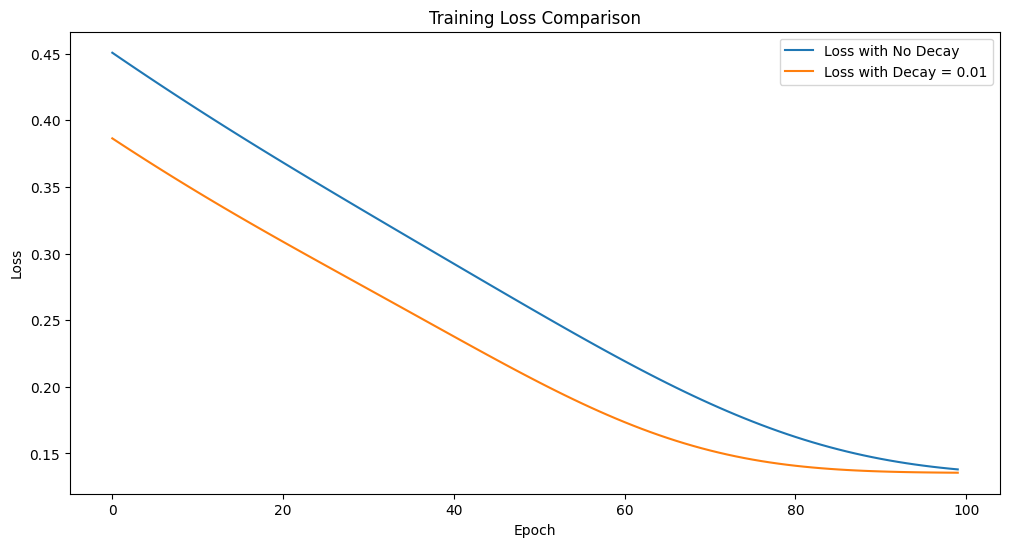

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(loss_no_decay, label = 'Loss with No Decay')
plt.plot(loss_decay, label = 'Loss with Decay = 0.01')
plt.title('Training Loss Comparison')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ppl give vague guidlines about constructing neural netowrks
# another small problem once you construct nn want to use model somewhere
# for multiapplications, you have target output and want to find suitable input, reverse optimization

# from there having dynamic model and make code for mpc, target y and decide input